# Optimal Planer Circle to Circle Orbit Transfer
This problem was recreated from Optimal Control with Aerospace Applications by James M. Longuski, Jose J. Guzman and John E. Prussing.  Thank you all for this (and Jose, sorry for not figuring out accents in Markdown, and we should talk about the difficulties you had in Appendix C.  A rule of thumb that works for pure numerical methods fails for indirect methods and I think that caused problems for you).

We are going to solve the optimal continuous thrust transfer between 2 circular orbits in the same orbit plane.  The specifics of the problem are posed as transfer from a low-Earth orbit to a Geo orbit.  We will start with the equations of motion, constants and constraints, and go through deriving the optimal control conditions that we can solve (the indirect method).  Then, we will solve the problem using direct methods leveraging the python library pyomo.

Note that included in this folder are two files, one for the indirect method and one for the direct (pyomo) method that are a single script. If you want to start editing things, I highly recommend playing with those instead of this juypter notebook.

## The Indirect Method

We start with importing all of the python libraries that we need for the indirect methods.

In [1]:
import sys
import os
sys.path.insert(1, os.path.dirname(os.path.dirname(sys.path[0]))) # need to import 2 directories up
# these two appends do not conflict with each-other

from IPython.display import display
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import math
from scipy.optimize import fsolve
from pyeq2orb.SymbolicOptimizerProblem import SymbolicProblem
from pyeq2orb.ScaledSymbolicProblem import ScaledSymbolicProblem
from pyeq2orb.Problems.ContinuousThrustCircularOrbitTransfer import ContinuousThrustCircularOrbitTransferProblem
from pyeq2orb.Numerical import ScipyCallbackCreators
from pyeq2orb.Numerical.LambdifyHelpers import LambdifyHelper, OdeLambdifyHelperWithBoundaryConditions
from pyeq2orb.Utilities.SolutionDictionaryFunctions import GetValueFromStateDictionaryAtIndex
import scipyPaperPrinter as jh
from datetime import datetime
print(str(datetime.now()))
# constants
g = 9.80665
mu = 3.986004418e14  
thrust = 20.0
isp = 6000.0
m0 = 1500.0

# initial values
r0 = 6678000.0
u0 = 0.0
v0 = sy.sqrt(mu/r0) # circular
lon0 = 0.0
# I know from many previous runs that this is the time needed to go from LEO to GEO.
# However, below works well wrapped in another fsolve to control the final time for a desired radius.
tfVal  = 3600*3.97152*24 
tfOrg = tfVal

2024-01-02 18:34:16.240590


We have a few choices to make.  Scaling the problem often leads to better convergence behavior.  This problem is set up to scale or not with a changing of this boolean.  There are 2 things we can scale.  The orbital elements, and/or the time.  I haven't really looked at scaling the time without scaling the elements too, but there's no reason why you can.

We also start defining our problem here.

In [2]:
# these are options to switch to try different things
scaleElements = False
scaleTime = scaleElements and True

# make the time array
tArray = np.linspace(0.0, tfOrg, 1200)
if scaleTime:
    tfVal = 1.0
    tArray = np.linspace(0.0, 1.0, 1200)

In [3]:
baseProblem = ContinuousThrustCircularOrbitTransferProblem()

initialStateValues = baseProblem.CreateVariablesAtTime0(baseProblem.StateVariables)
problem = baseProblem

if scaleElements :
    newSvs = ScaledSymbolicProblem.CreateBarVariables(problem.StateVariables, problem.TimeSymbol) 
    #TODO this next bit could be cleaner...
    problem = ScaledSymbolicProblem(baseProblem, newSvs, {problem.StateVariables[0]: initialStateValues[0], 
                                                          problem.StateVariables[1]: initialStateValues[2], 
                                                          problem.StateVariables[2]: initialStateValues[2], 
                                                          problem.StateVariables[3]: 1} , scaleTime)

stateAtTf = SafeSubs(problem.StateVariables, {problem.TimeSymbol: problem.TimeFinalSymbol})

# register constants (this dictionary gets shared around)
constantsSubsDict = problem.SubstitutionDictionary
constantsSubsDict[baseProblem.Isp] = isp
constantsSubsDict[baseProblem.MassInitial] = m0
constantsSubsDict[baseProblem.Gravity] = g
constantsSubsDict[baseProblem.Mu]= mu
constantsSubsDict[baseProblem.Thrust] = thrust

# register initial state values
constantsSubsDict.update(zip(initialStateValues, [r0, u0, v0, lon0]))
if scaleElements :
    # and reset the real initial values using tau_0 instead of time
    initialValuesAtTau0 = SafeSubs(initialStateValues, {baseProblem.TimeInitialSymbol: problem.TimeInitialSymbol})
    constantsSubsDict.update(zip(initialValuesAtTau0, [r0, u0, v0, lon0]))

    r0= r0/r0
    u0=u0/v0
    v0=v0/v0
    lon0=lon0/1.0
    # add the scaled initial values (at tau_0).  We should NOT need to add these at t_0
    initialScaledStateValues = problem.CreateVariablesAtTime0(problem.StateVariables)
    constantsSubsDict.update(zip(initialScaledStateValues, [r0, u0, v0, lon0]))     


    
problem.Lambdas.extend(problem.CreateCoVector(problem.StateVariables, r'\lambda', problem.TimeSymbol)) # preemptively making the costate values


TypeError: descriptor '__init__' requires a 'super' object but received a 'ContinuousThrustCircularOrbitTransferProblem'

There is a non-trivial amount of code in both the ContinuousThrustCircularOrbitTransferProblem and in the ScaledSymbolicProblem.  Because I like to keep the equations symbolic as I go, I end up registering the various constants in the system in a dictionary.

At this point, let's state our problem.  We want to find the optimal continuous thrust transfer between 2 coplanar circular orbits.  For this particular problem, we pose it as maximizing the final radius and constraining the final orbit to be a circle (we do not constrain the final longitude).

In [ ]:
jh.t = problem._timeSymbol # needed for cleaner printed equations

jh.printMarkdown("With a given final time, maximize:")
jh.showEquation("J", baseProblem.CostFunction, False)
jh.printMarkdown("We will find the optimal thrust vector $\\alpha(t)$ to achieve this transfer.")

jh.printMarkdown("With the following equations of motion:")
for sv,eq in baseProblem.EquationsOfMotion.items() :
    jh.showEquation(sv, eq)

jh.printMarkdown("There are known initial values.  Additionally, we have the following constraints.  The orbit must be circular resulting in $v(t_f)$ obeying a specific equation and $u(t_f)=0$.")
for bc in baseProblem.BoundaryConditions :
    jh.showEquation(0, bc, False)



With a given final time, maximize:

Eq(J, r(t_f))

We will find the optimal thrust vector $\alpha(t)$ to achieve this transfer.

With the following equations of motion:

Eq(r, u)

Eq(u, T*sin(\alpha)/(m_0 - T*t/(I_{sp}*g)) - \mu/r**2 + v**2/r)

Eq(v, T*cos(\alpha)/(m_0 - T*t/(I_{sp}*g)) - u*v/r)

Eq(\theta, v/r)

There are known initial values.  Additionally, we have the following constraints.  The orbit must be circular resulting in $v(t_f)$ obeying a specific equation and $u(t_f)=0$.

Eq(0, u(t_f))

Eq(0, -sqrt(\mu)/sqrt(r(t_f)) + v(t_f))

Now we go through the fairly standard sequence of deriving the optimality conditions.  However, there is enough that makes me hesitate turning this into a standard reusable function.  Almost all optimization problems will require some code to be written and although being concise is good, shorter is not always better than readable.  Better to make it a clear demo.  We create the costate time-varying symbols, adjoin them to the equations of motion, and use the optimal control conditions to derive their equations of motion and derive additional constraints.

In [ ]:
# this next block does most of the problem, pretty standard optimal control actions
lambdas = problem.Lambdas
hamiltonian = problem.CreateHamiltonian(lambdas)
jh.showEquation("H", hamiltonian)
lambdaDotExpressions = problem.CreateLambdaDotCondition(hamiltonian)
for i in range(0, 4):
    jh.showEquation(lambdas[i].diff(problem.TimeSymbol), lambdaDotExpressions[i, 0])
# NOTE that this call adds the lambdas to the integration state!
problem.EquationsOfMotion.update(zip(lambdas, lambdaDotExpressions))

dHdu = problem.CreateHamiltonianControlExpressions(hamiltonian)[0]
jh.showEquation('\\frac{\\partial{H}}{\\partial{u}}=0', dHdu)
jh.printMarkdown("Note that because time is explicitly in the Hamiltonian, the partial and total derivatives of H with respect to the controls are not equivalent.  Also the Hamiltonian along the optimal solution will not be constant")
jh.printMarkdown("We can use this equation to make an expression for the control variable.")

controlSolved = sy.solve(dHdu, problem.ControlVariables[0])[0] # something that may be different for other problems is when there are multiple control variables
jh.showEquation(problem.ControlVariables[0], controlSolved)

# update ALL equations of motion with the new expression for the control variable
SafeSubs(problem.EquationsOfMotion, {problem.ControlVariables[0]: controlSolved})
# the trig simplification needs the deep=True for this problem to make the equations even cleaner
for (key, value) in problem.EquationsOfMotion.items() :
    problem.EquationsOfMotion[key] = value.trigsimp(deep=True).simplify() # some simplification to make numerical code more stable later, and that is why this code forces us to do things somewhat manually.  There are often special things like this that we ought to do that you can't really automate.
    jh.showEquation(key.diff(problem.TimeSymbol), problem.EquationsOfMotion[key])
jh.printMarkdown("Note the use of the deep parameter when we do the trig simplification.  It is little things like that that require each problem to be a little unique.")


Eq(H, \lambda_{\theta}*v/r + \lambda_{r}*u + \lambda_{u}*(T*sin(\alpha)/(m_0 - T*t/(I_{sp}*g)) - \mu/r**2 + v**2/r) + \lambda_{v}*(T*cos(\alpha)/(m_0 - T*t/(I_{sp}*g)) - u*v/r))

Eq(Derivative(\lambda_{r}, t), \lambda_{\theta}*v/r**2 - \lambda_{u}*(2*\mu/r**3 - v**2/r**2) - \lambda_{v}*u*v/r**2)

Eq(Derivative(\lambda_{u}, t), -\lambda_{r} + \lambda_{v}*v/r)

Eq(Derivative(\lambda_{v}, t), -\lambda_{\theta}/r - 2*\lambda_{u}*v/r + \lambda_{v}*u/r)

Eq(Derivative(\lambda_{\theta}, t), 0)

Eq(\frac{\partial{H}}{\partial{u}}=0, T*\lambda_{u}*cos(\alpha)/(m_0 - T*t/(I_{sp}*g)) - T*\lambda_{v}*sin(\alpha)/(m_0 - T*t/(I_{sp}*g)))

Note that because time is explicitly in the Hamiltonian, the partial and total derivatives of H with respect to the controls are not equivalent.  Also the Hamiltonian along the optimal solution will not be constant

We can use this equation to make an expression for the control variable.

Eq(\alpha, 2*atan((-\lambda_{v} + sqrt(\lambda_{u}**2 + \lambda_{v}**2))/\lambda_{u}))

Eq(Derivative(r, t), u)

Eq(Derivative(u, t), T*\lambda_{u}*(-\lambda_{v} + sqrt(\lambda_{u}**2 + \lambda_{v}**2))/((m_0 - T*t/(I_{sp}*g))*(\lambda_{u}**2 + \lambda_{v}**2 - \lambda_{v}*sqrt(\lambda_{u}**2 + \lambda_{v}**2))) - \mu/r**2 + v**2/r)

Eq(Derivative(v, t), (I_{sp}*T*\lambda_{v}*g*r*(-\lambda_{v} + sqrt(\lambda_{u}**2 + \lambda_{v}**2)) - u*v*(I_{sp}*g*m_0 - T*t)*(\lambda_{u}**2 + \lambda_{v}**2 - \lambda_{v}*sqrt(\lambda_{u}**2 + \lambda_{v}**2)))/(r*(I_{sp}*g*m_0 - T*t)*(\lambda_{u}**2 + \lambda_{v}**2 - \lambda_{v}*sqrt(\lambda_{u}**2 + \lambda_{v}**2))))

Eq(Derivative(\theta, t), v/r)

Eq(Derivative(\lambda_{r}, t), (-\lambda_{u}*(2*\mu - r*v**2) + r*v*(\lambda_{\theta} - \lambda_{v}*u))/r**3)

Eq(Derivative(\lambda_{u}, t), -\lambda_{r} + \lambda_{v}*v/r)

Eq(Derivative(\lambda_{v}, t), (-\lambda_{\theta} - 2*\lambda_{u}*v + \lambda_{v}*u)/r)

Eq(Derivative(\lambda_{\theta}, t), 0)

Note the use of the deep parameter when we do the trig simplification.  It is little things like that that require each problem to be a little unique.

We have another choice to make; the transversality condition.  In optimal control theory, the transversality condition provides another optimality condition that we can solve for.  It is a necessary condition both in the "necessary and sufficient" context, but also to provide enough non-trivial boundary conditions to solve for.  

The first of the two forms is the adjoined method.  Here, the transversality condition is created by by creating additional final (not time varying) scalers that multiply the constraints and get combined with the terminal cost.  The second way is the differential form of the transversality condition that doesn't add in additional variables to solve for.  Really, neither is better or worse (especially for this problem), and I'm just going to pick the differential form.

Long story short, we get additional NECESSARY boundary conditions for solving for the alpha that makes the cost stationary if we add in an error variation to the cost.

In [ ]:
# your choice of the nu vector here controls which transversality condition we use
#nus = [sy.Symbol('B_{u_f}'), sy.Symbol('B_{v_f}')]
nus = []

# make the transversality conditions
if len(nus) != 0:
    transversalityCondition = problem.TransversalityConditionsByAugmentation(nus)
else:
    transversalityCondition = problem.TransversalityConditionInTheDifferentialForm(hamiltonian, sy.Symbol(r'dt_f'))
# and add them to the problem
problem.BoundaryConditions.extend(transversalityCondition)
jh.printMarkdown("Note that the implementation of the scaled problem actually derives the transversality conditions for the unscaled problem, and then after the condition is derived, the substituted variables are entered.  This way there is the opportunity for values to get canceled out.")
jh.printMarkdown("The transversality conditions are:")
for xvers in transversalityCondition :
    jh.showEquation(0, xvers)

#TODO: This is a bad order of operations bug.  The final-time BC cannot be present in the base problem's BC's when the transversality conditions are made
if scaleTime : # add BC if we are working with the final time (not all solvers need this, but when the same number of BC's and variables are required by the solver [like fsolve does] then...)
    problem.BoundaryConditions.append(baseProblem.TimeFinalSymbol-tfOrg)

jh.printMarkdown("Despite this being a maximization problem, the differential form of the transversality condition will NOT multiply the terminal cost by -1 to make the maximization problem a minimization problem.  I have not been able to find any reasonable justification for that other than 'it works' for numerical solvers.  This is one of the necessary optimality conditions that only finds a stationary point.  It doesn't matter if we are finding a minimum or maximum, the terminal cost doesn't gets its sign flipped.")

Note that the implementation of the scaled problem actually derives the transversality conditions for the unscaled problem, and then after the condition is derived, the substituted variables are entered.  This way there is the opportunity for values to get canceled out.

The transversality conditions are:

Eq(0, -\lambda_{r} + \lambda_{v}*sqrt(\mu)/(2*r**(3/2)) + 1)

Eq(0, -\lambda_{\theta})

Despite this being a maximization problem, the differential form of the transversality condition will NOT multiply the terminal cost by -1 to make the maximization problem a minimization problem.  I have not been able to find any reasonable justification for that other than 'it works' for numerical solvers.  This is one of the necessary optimality conditions that only finds a stationary point.  It doesn't matter if we are finding a minimum or maximum, the terminal cost doesn't gets its sign flipped.

Note that the final value for the costate value associated with the longitude is 0, as is its equation of motion.  We will remove it from consideration.

In [ ]:
# lambda_lon is always 0, so do that cleanup
del problem.EquationsOfMotion[lambdas[3]]
problem.BoundaryConditions.remove(transversalityCondition[-1])
lmdTheta = lambdas.pop()
problem.IntegrationSymbols.pop()
constantsSubsDict[lmdTheta]=0
constantsSubsDict[lmdTheta.subs(problem.TimeSymbol, problem.TimeFinalSymbol)]=0
constantsSubsDict[lmdTheta.subs(problem.TimeSymbol, problem.TimeInitialSymbol)]=0

The next line of code is making our initial guesses for the costate variables.  The general process is based on the intuition that the thrust should be going forward in the direction of the velocity.  Solving the control angle to be 0 at $t_0$ gives us 0 for one of them and about 1 for the other.  However from experience, setting one of the costate values to 0 usually has problems, so we set it to a low number.  Those 2 costate variables lets us solve for the third, giving us our first guess that is hopefully close enough.

In [ ]:
initialFSolveStateGuess = ContinuousThrustCircularOrbitTransferProblem.CreateInitialLambdaGuessForLeoToGeo(problem, controlSolved)
if scaleTime :
    initialFSolveStateGuess.append(tfOrg)

We now start the transformation to a numerical algorithm that we can solve.  Note that if you change which form of the transversality condition you are using, different values will get substituted here.

In [ ]:
otherArgs = []
if scaleTime :
    otherArgs.append(baseProblem.TimeFinalSymbol)
if len(nus) > 0 :
    otherArgs.extend(nus)
stateAndLambdas = []
stateAndLambdas.extend(problem.StateVariables)
stateAndLambdas.extend(lambdas)
odeState = [problem.TimeSymbol, stateAndLambdas, otherArgs]

lambdifyHelper = OdeLambdifyHelperWithBoundaryConditions(problem.TimeSymbol, problem.TimeInitialSymbol, problem.TimeFinalSymbol, problem.EquationsOfMotionAsEquations, problem.BoundaryConditions, otherArgs, problem.SubstitutionDictionary)


Lambdify is the function that saves a ton of time and possible errors.  This turns our symbolic expressions into code that runs at normal or faster speeds (using libraries like numpy for additional performance) instead of substituting in values when we go to evaluate the equations of motion which would be very slow.  

In [ ]:
# this next block is for when we are using the adjoined form of the transversality condition.  However it is also REALLY useful to just have 
# the equations of motion in a form that we can evaluate ourselves.
odeIntEomCallback = lambdifyHelper.CreateSimpleCallbackForSolveIvp()
if len(nus) > 0 :
    # run a test solution to get a better guess for the final nu values, this is a good technique, but 
    # it is still a custom-to-this-problem piece of code because it is still initial-guess work
    initialFSolveStateGuess.append(initialFSolveStateGuess[1])
    initialFSolveStateGuess.append(initialFSolveStateGuess[2])  
    argsForOde = []
    if scaleTime :
        argsForOde.append(tfOrg)
    argsForOde.append(initialFSolveStateGuess[1])
    argsForOde.append(initialFSolveStateGuess[2])  
    print("solving ivp for final ajoined variable guess")
    testSolution = solve_ivp(odeIntEomCallback, [tArray[0], tArray[-1]], [r0, u0, v0, lon0, *initialFSolveStateGuess[0:3]], args=tuple(argsForOde), t_eval=tArray, dense_output=True, method="LSODA", rtol=1.49012e-8, atol=1.49012e-11)  
    #testSolution = odeint(odeIntEomCallback, [r0, u0, v0, lon0, *initialFSolveStateGuess[0:3]], tArray, args=tuple(argsForOde))
    finalValues = ScipyCallbackCreators.GetFinalStateFromIntegratorResults(testSolution)
    initialFSolveStateGuess[-2] = finalValues[5]
    initialFSolveStateGuess[-1] = finalValues[6]

Now we create the boundary condition evaluation callback.  Note that making this callback general is difficult.  I'm using scipy's solveIvp for the integration of the eqations of motion, but what if you want to use some other routine?  Some of the initial values and final values that are passed to the fsolve boundary condition values, and some of those values also need to get placed into the initial values for the equations of motion... it is can't be easily generalized for most problems, but it doesn't really change for this problem.

That being said, streamlining this part of the process is something I am continuing to think about.

In [ ]:
stateForBoundaryConditions = []
stateForBoundaryConditions.extend(SafeSubs(problem.IntegrationSymbols, {problem.TimeSymbol: problem.TimeInitialSymbol}))
stateForBoundaryConditions.extend(SafeSubs(problem.IntegrationSymbols, {problem.TimeSymbol: problem.TimeFinalSymbol}))
stateForBoundaryConditions.extend(lambdas)
stateForBoundaryConditions.extend(otherArgs)

fSolveCallback = ContinuousThrustCircularOrbitTransferProblem.createSolveIvpSingleShootingCallbackForFSolve(problem, problem.IntegrationSymbols, [r0, u0, v0, lon0], tArray, odeIntEomCallback, problem.BoundaryConditions, SafeSubs(lambdas, {problem.TimeSymbol: problem.TimeInitialSymbol}), otherArgs)

In [ ]:
print(initialFSolveStateGuess)
fSolveSol = fsolve(fSolveCallback, initialFSolveStateGuess, epsfcn=0.00001, full_output=True) # just to speed things up and see how the initial one works
print(fSolveSol)

[0.0011569091762708, 0.00010000000130634948, 1.0]
(array([   26.22754265,  1277.07962758, 23647.71906124]), {'nfev': 79, 'fjac': array([[-9.99970746e-01, -7.62548671e-03, -5.99436585e-04],
       [ 7.62544945e-03, -9.99970924e-01,  6.44205089e-05],
       [ 5.99910393e-04, -5.98476509e-05, -9.99999818e-01]]), 'r': array([-2.52184098e+03,  1.85013533e+00, -3.37806333e+00, -1.80516270e-01,
        1.35966329e-01, -1.25506481e-04]), 'qtf': array([-3.00931567e-04,  9.27589209e-05, -1.16254530e-07]), 'fvec': array([ 3.01630022e-04, -9.04614672e-05,  3.02619477e-07])}, 1, 'The solution converged.')


Yay, it says it converged.  Let's see what we have.

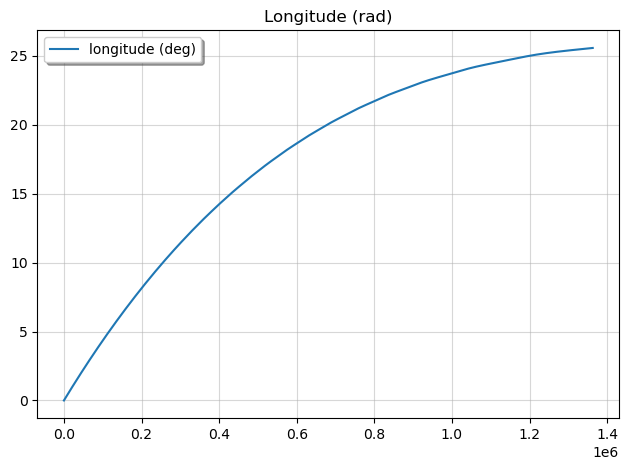

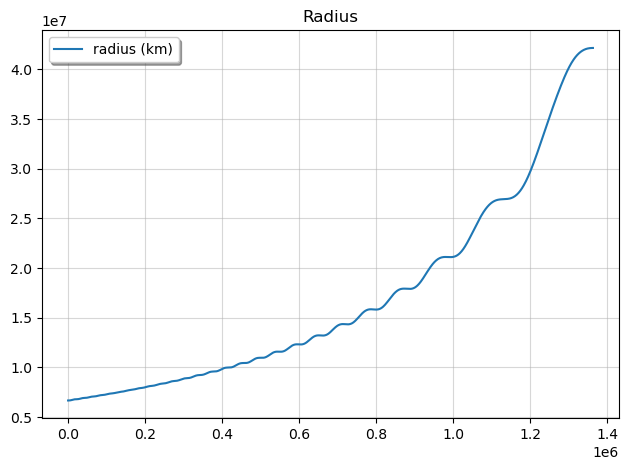

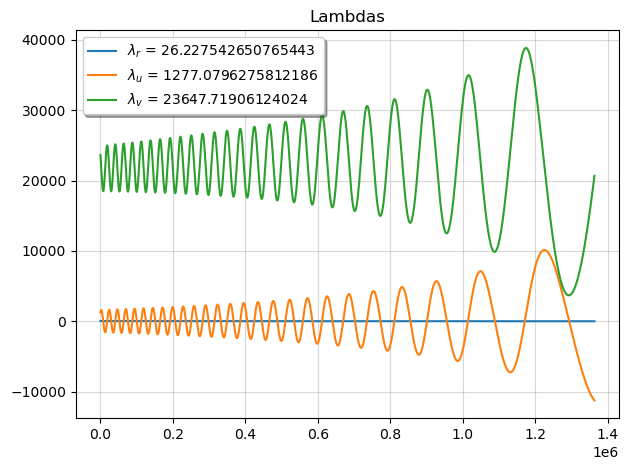

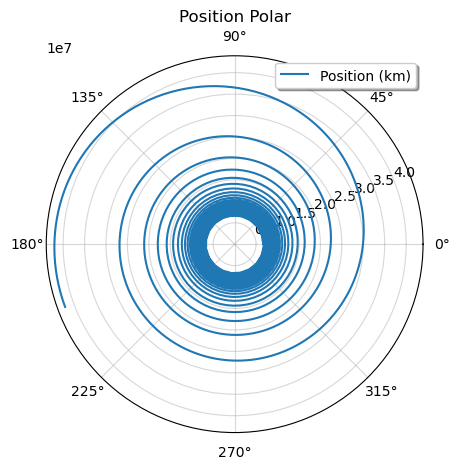

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


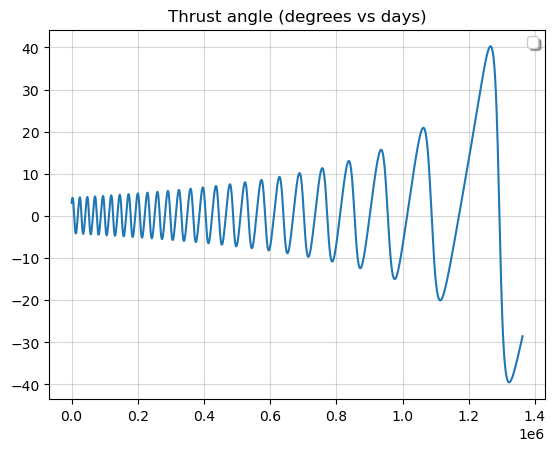

Eq(r(t_f), 42162089.1906473)

Eq(u(t_f), 0.000301630022403243)

Eq(v(t_f), 3074.73586567063)

Eq(\theta(t_f), 100.151647534735)

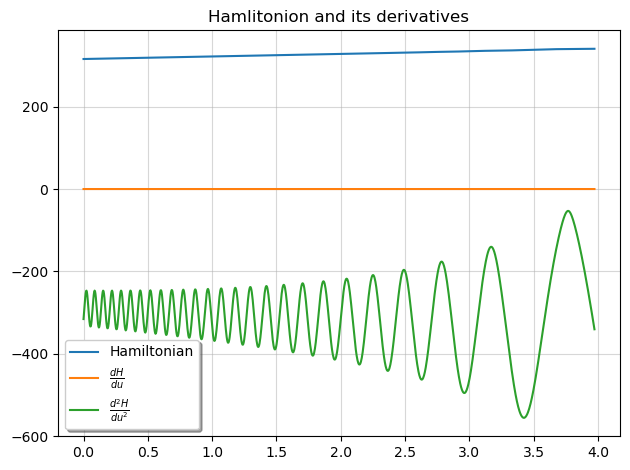

In [ ]:
solution = solve_ivp(odeIntEomCallback, [tArray[0], tArray[-1]], [r0, u0, v0, lon0, *fSolveSol[0][0:3]], args=tuple(fSolveSol[0][3:len(fSolveSol[0])]), t_eval=tArray, dense_output=True, method="LSODA", rtol=1.49012e-8, atol=1.49012e-11)
solutionDictionary = ScipyCallbackCreators.ConvertEitherIntegratorResultsToDictionary(problem.IntegrationSymbols, solution)
unscaledResults = solutionDictionary
unscaledTArray = tArray
unscaledResults = problem.DescaleResults(solutionDictionary)
if scaleTime:
    unscaledTArray=tfOrg*tArray

if scaleElements:    
    finalState = GetValueFromStateDictionaryAtIndex(solutionDictionary, -1)
    jh.showEquation(stateAtTf[0], finalState[problem.StateVariables[0]], False)
    jh.showEquation(stateAtTf[1], finalState[problem.StateVariables[1]], False)
    jh.showEquation(stateAtTf[2], finalState[problem.StateVariables[2]], False)
    jh.showEquation(stateAtTf[3], (finalState[problem.StateVariables[3]]%(2*math.pi))*180.0/(2*math.pi), False)

baseProblem.PlotSolution(tArray*tfOrg, unscaledResults, "Test")
jh.showEquation(baseProblem.StateVariables[0].subs(problem.TimeSymbol, problem.TimeFinalSymbol), unscaledResults[baseProblem.StateVariables[0]][-1], False)
jh.showEquation(baseProblem.StateVariables[1].subs(problem.TimeSymbol, problem.TimeFinalSymbol), unscaledResults[baseProblem.StateVariables[1]][-1], False)
jh.showEquation(baseProblem.StateVariables[2].subs(problem.TimeSymbol, problem.TimeFinalSymbol), unscaledResults[baseProblem.StateVariables[2]][-1], False)
jh.showEquation(baseProblem.StateVariables[3].subs(problem.TimeSymbol, problem.TimeFinalSymbol), (unscaledResults[baseProblem.StateVariables[3]][-1]%(2*math.pi))*180.0/(2*math.pi), False)

[hamltVals, dhduValus, d2hdu2Valus] = problem.EvaluateHamiltonianAndItsFirstTwoDerivatives(solutionDictionary, tArray, hamiltonian, {problem.ControlVariables[0]: controlSolved}, {baseProblem.TimeFinalSymbol: tfOrg})
plt.title("Hamlitonion and its derivatives")
plt.plot(tArray/86400, hamltVals, label="Hamiltonian")
plt.plot(tArray/86400, dhduValus, label=r'$\frac{dH}{du}$')
plt.plot(tArray/86400, d2hdu2Valus, label=r'$\frac{d^2H}{du^2}$')

plt.tight_layout()
plt.grid(alpha=0.5)
plt.legend(framealpha=1, shadow=True)
plt.show()   

The second derivative of the Hamiltonian is negative which satisfies the sufficient condition for a maximization problem.  The plots are also identical to the plots from Dr. Gusman's outputs.  All in all, we can be very confident that this solution is indeed an optimal one.

# Direct Method

For the direct method, it will start similar to the previous one.  We have to make our problem class, register the constants, etc...  Note that compared to the indirect version, this routine has not been as well tested and refined.

In [ ]:
import __init__
import sys
sys.path.append("..") # treating this as a jupyter-like cell requires adding one directory up
sys.path.append("../pyeq2orb") # and this line is needed for running like a normal python script
# these two appends do not conflict with eachother
import math
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# to get pyomo to work on windows, must also install this library:
# conda install -c conda-forge pynumero_libraries

from pyeq2orb.SymbolicOptimizerProblem import SymbolicProblem
from pyeq2orb.ScaledSymbolicProblem import ScaledSymbolicProblem
from pyeq2orb.Problems.ContinuousThrustCircularOrbitTransfer import ContinuousThrustCircularOrbitTransferProblem
from pyeq2orb.Numerical import ScipyCallbackCreators
import scipyPaperPrinter as jh
import pyomo.environ as poenv
import pyomo.dae as podae
from matplotlib.figure import Figure
from pyeq2orb.NumericalProblemFromSymbolic import NumericalProblemFromSymbolicProblem

# constants
g = 9.80665
mu = 3.986004418e14  
thrust = 20.0
isp = 6000.0
m0 = 1500.0

# initial values
r0 = 6678000.0
u0 = 0.0
v0 = sy.sqrt(mu/r0) # circular
lon0 = 0.0
# I know from many previous runs that this is the time needed to go from LEO to GEO.
# However, below works well wrapped in another fsolve to control the final time for a desired radius.
tfVal  = 3600*3.97152*24
tfOrg = tfVal

# these are options to switch to try different things
scale = True
scaleTime = True

baseProblem = ContinuousThrustCircularOrbitTransferProblem()
initialStateValues = baseProblem.CreateVariablesAtTime0(baseProblem.StateVariables)
problem = baseProblem

if scale :
    newSvs = ScaledSymbolicProblem.CreateBarVariables(problem.StateVariables, problem.TimeSymbol) 
    problem = ScaledSymbolicProblem(baseProblem, newSvs, {problem.StateVariables[0]: initialStateValues[0], 
                                                          problem.StateVariables[1]: initialStateValues[2], 
                                                          problem.StateVariables[2]: initialStateValues[2], 
                                                          problem.StateVariables[3]: 1.0} , scaleTime)
rs = problem.StateVariables[0]
us = problem.StateVariables[1]
vs = problem.StateVariables[2]
lons = problem.StateVariables[3]

jh.t = problem._timeSymbol

# register constants
constantsSubsDict = problem.SubstitutionDictionary
constantsSubsDict[baseProblem.Isp] = isp
constantsSubsDict[baseProblem.MassInitial] = m0
constantsSubsDict[baseProblem.Gravity] = g
constantsSubsDict[baseProblem.Mu]= mu
constantsSubsDict[baseProblem.Thrust] = thrust

# register initial state values
constantsSubsDict.update(zip(initialStateValues, [r0, u0, v0, lon0]))
if scale :
    # and reset the real initial values using tau_0 instead of time
    initialValuesAtTau0 = SafeSubs(initialStateValues, {baseProblem.TimeInitialSymbol: problem.TimeInitialSymbol})
    constantsSubsDict.update(zip(initialValuesAtTau0, [r0, u0, v0, lon0]))

    r0= r0/r0
    u0=u0/v0
    v0=v0/v0
    lon0=lon0/1.0
    # add the scaled initial values (at tau_0).  We should NOT need to add these at t_0
    initialScaledStateValues = problem.CreateVariablesAtTime0(problem.StateVariables)
    constantsSubsDict.update(zip(initialScaledStateValues, [r0, u0, v0, lon0])) 

In [ ]:
jh.printMarkdown("Now we start setting up our pyomo problem. There is a wrapper class that takes a symbolic problem and turns it into a numerical problem.  It is still a prototype, but this kind of wrapping is I think the way to go.")

lambdiafyFunctionMap = {'sqrt': poenv.sqrt, 'sin': poenv.sin, 'cos':poenv.cos} #TODO: MOOOORE!!!!
asNumericalProblem = NumericalProblemFromSymbolicProblem(problem, lambdiafyFunctionMap)

n=200
tSpace = np.linspace(0.0, 1.0, n)

jh.printMarkdown("And here is where we start setting up pyomo. In terms of using pyomo, this is all pretty standard so far...")
model = poenv.ConcreteModel()
model.t = podae.ContinuousSet(initialize=tSpace, domain=poenv.NonNegativeReals)

velBound = float(1.5*abs(v0))
model.r = poenv.Var(model.t, bounds=(0.9, 8.0), initialize=float(r0))
model.u = poenv.Var(model.t, bounds=(-1.0*velBound, velBound), initialize=float(u0))
model.v = poenv.Var(model.t, bounds=(-1.0*velBound, velBound), initialize=float(v0))
model.lon = poenv.Var(model.t, bounds=(lon0, 29.0*2.0*math.pi), initialize=float(lon0))
model.control = poenv.Var(model.t, bounds=(-1.0*math.pi/2.2, math.pi/2.2))
model.tf = poenv.Var(bounds=(tfOrg-2, tfOrg+2), initialize=float(tfOrg))

model.r[0].fix(float(r0))
model.u[0].fix(float(u0))
model.v[0].fix(float(v0))
model.lon[0].fix(float(lon0))

model.rDot = podae.DerivativeVar(model.r, wrt=model.t)
model.uDot = podae.DerivativeVar(model.u, wrt=model.t)
model.vDot = podae.DerivativeVar(model.v, wrt=model.t)
model.lonDot = podae.DerivativeVar(model.lon, wrt=model.t)

Now we start setting up our pyomo problem. There is a wrapper class that takes a symbolic problem and turns it into a numerical problem.  It is still a prototype, but this kind of wrapping is I think the way to go.

And here is where we start setting up pyomo. In terms of using pyomo, this is all pretty standard so far...

In [ ]:
jh.printMarkdown("Here, we create a helper function to map the state that pyomo can give to the callbacks and functions that the numerical problem type provides.")

def mapPyomoStateToProblemState(m, t, callableExpression) :
    return callableExpression([t, m.r[t], m.u[t], m.v[t], m.lon[t], m.control[t], m.tf])

jh.printMarkdown("With this, we can set up our equations of motions, our terminal constraints, and the objective function.")

model.rEom = poenv.Constraint(model.t, rule =lambda m, t2: m.rDot[t2] == mapPyomoStateToProblemState(m, t2, lambda state : asNumericalProblem.SingleEquationOfMotionWithTInState(state, 0)))
model.uEom = poenv.Constraint(model.t, rule =lambda m, t2: m.uDot[t2] == mapPyomoStateToProblemState(m, t2, lambda state : asNumericalProblem.SingleEquationOfMotionWithTInState(state, 1)))
model.vEom = poenv.Constraint(model.t, rule =lambda m, t2: m.vDot[t2] == mapPyomoStateToProblemState(m, t2, lambda state : asNumericalProblem.SingleEquationOfMotionWithTInState(state, 2)))
model.lonEom = poenv.Constraint(model.t, rule =lambda m, t2: m.lonDot[t2] == mapPyomoStateToProblemState(m, t2, lambda state : asNumericalProblem.SingleEquationOfMotionWithTInState(state, 3)))

model.bc1 = poenv.Constraint(rule = lambda mod1 : 0 == mapPyomoStateToProblemState(mod1, 1.0, asNumericalProblem.BoundaryConditionCallbacks[0]))
model.bc2 = poenv.Constraint(rule = lambda mod1 : 0 == mapPyomoStateToProblemState(mod1, 1.0, asNumericalProblem.BoundaryConditionCallbacks[1]))

def singlePyomoArrayToTerminalCostCallback(m, t, expr) :
    return expr(m.tf, [t, m.r[t], m.u[t], m.v[t], m.lon[t], m.control[t]])
finalRadiusCallback = lambda m : singlePyomoArrayToTerminalCostCallback(m, 1.0, asNumericalProblem.TerminalCost)
model.radiusObjective = poenv.Objective(expr = finalRadiusCallback, sense=poenv.maximize)

Here, we create a helper function to map the state that pyomo can give to the callbacks and functions that the numerical problem type provides.

With this, we can set up our equations of motions, our terminal constraints, and the objective function.

In [ ]:
jh.printMarkdown("Next, we setup our initial values and run a simulation to get an initial guess for the problem.")

model.var_input = poenv.Suffix(direction=poenv.Suffix.LOCAL)
model.var_input[model.control] = {0: 0.03}
model.var_input[model.tf] = {0: tfOrg}

sim = podae.Simulator(model, package='scipy') 
tsim, profiles = sim.simulate(numpoints=n, varying_inputs=model.var_input, integrator='dop853', initcon=np.array([r0,u0, v0, lon0], dtype=float))

Next, we setup our initial values and run a simulation to get an initial guess for the problem.

In [ ]:
jh.printMarkdown("Simulating the problem is required before solving it.  One thing I am planning to look into is initializing a problem if it is simulated in some other way (such as from the results of an indirect solver).  But now we can solve it.  IPOPT is, as far as I know, the best solver I have access to that can solve this kind of nonlinear programming problem.")

poenv.TransformationFactory('dae.collocation').apply_to(model, wrt=model.t, nfe=n,ncp=3, scheme='LAGRANGE-RADAU')
sim.initialize_model()
solver = poenv.SolverFactory('cyipopt')
solver.solve(model, tee=True)

Simulating the problem is required before solving it.  One thing I am planning to look into is initializing a problem if it is simulated in some other way (such as from the results of an indirect solver).  But now we can solve it.  IPOPT is, as far as I know, the best solver I have access to that can solve this kind of nonlinear programming problem.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    22800
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6003

Total number of variables............................:     5406
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     3002
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4806
Total number of inequality c

{'Problem': [{'Name': 'unknown', 'Lower bound': -6.313517250472114, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 4806, 'Number of variables': 5406, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 5406, 'Sense': 'maximize'}], 'Solver': [{'Name': 'cyipopt', 'Status': 'ok', 'Return code': 0, 'Message': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).', 'Wallclock time': 1.282948900000001, 'Termination condition': 'optimal'}]}

With our solution, we can plot it as well as inspect the final variables.

control 0 = 4.379828737893024e-17


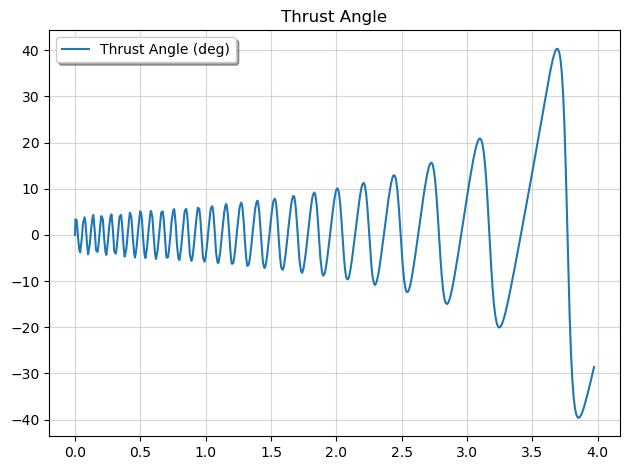

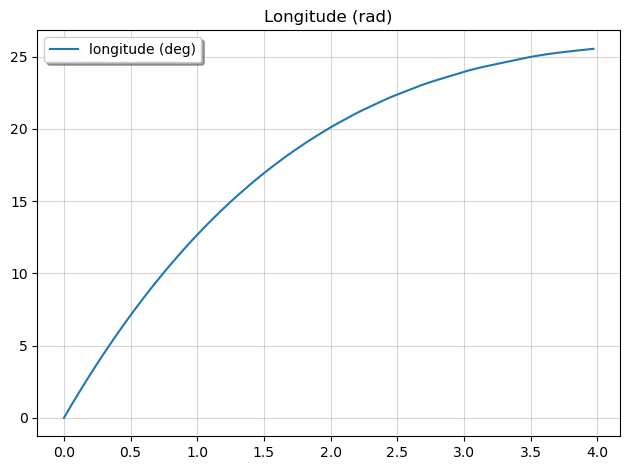

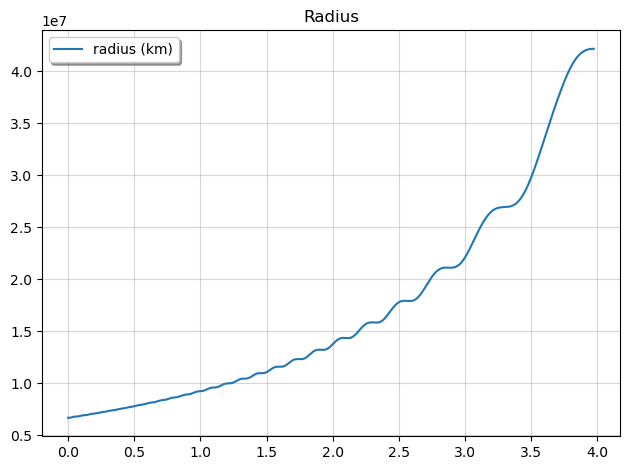

Tf = 3.9715431487364152


Eq(r_f, 42161668.1986528)

Eq(u_f, 1.3295357807946e-26)

Eq(v_f, 3074.75130699517)

2023-10-17 21:49:35.935915


In [ ]:
jh.printMarkdown("With our solution, we can plot it as well as inspect the final variables.")

def plotPyomoSolution(model, stateSymbols):
    tSpace =np.array( [t for t in model.t]) * model.tf.value
    rSym = np.array([model.r[t]() for t in model.t])
    uSym = np.array([model.u[t]() for t in model.t])
    vSym = np.array([model.v[t]() for t in model.t])
    lonSim = np.array([model.lon[t]() for t in model.t])
    controls = np.array([model.control[t]() for t in model.t])
    print("control 0 = " + str(controls[0]))
    plt.title("Thrust Angle")
    plt.plot(tSpace/86400, controls*180.0/math.pi, label="Thrust Angle (deg)")
    plt.tight_layout()
    plt.grid(alpha=0.5)
    plt.legend(framealpha=1, shadow=True)
    plt.show()    
    ansAsDict = OrderedDict()
    ansAsDict[stateSymbols[0]]= rSym
    ansAsDict[stateSymbols[1]]= uSym
    ansAsDict[stateSymbols[2]]= vSym
    ansAsDict[stateSymbols[3]]=  lonSim

    return [tSpace, ansAsDict]

[tArray, solutionDictionary] = plotPyomoSolution(model, problem.StateVariables)
unscaledResults = problem.DescaleResults(solutionDictionary)
baseProblem.PlotSolution(tArray, unscaledResults, "Leo to Geo")

print("Tf = " + str(model.tf.value/86400))
jh.showEquation("r_f", unscaledResults[baseProblem.StateVariables[0]][-1]) 
jh.showEquation("u_f", unscaledResults[baseProblem.StateVariables[1]][-1]) 
jh.showEquation("v_f", unscaledResults[baseProblem.StateVariables[2]][-1])    

xyz = np.zeros((len(tArray), 3))
for i in range(0, len(unscaledResults[baseProblem.StateVariables[0]])) :
    r = unscaledResults[baseProblem.StateVariables[0]][i]
    theta = unscaledResults[baseProblem.StateVariables[3]][i]
    x = r*math.cos(theta)
    y = r*math.sin(theta)
    xyz[i,0] = x
    xyz[i,1] = y
    xyz[i,2] = 0

import plotly.express as px
from pandas import DataFrame
df = DataFrame(xyz)

x = np.array(xyz[:,0])
y = np.array(xyz[:,1])
z = np.array(xyz[:,2])
df = DataFrame({"x": x, "y":y, "z":z})
fig = px.line_3d(df, x="x", y="y", z="z")
fig.show()
print(str(datetime.now()))

These results look very similar to the indirect results as expected.